In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import re

spark = SparkSession.builder.getOrCreate()

trending_path = "s3://yt-analytics-cs6705-data/curated/trending/"

trending_df = spark.read.parquet(trending_path)

trending_df.printSchema()


Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 1.0.7 
Trying to create a Glue session for the kernel.
Session Type: glueetl
Session ID: 696255ed-a44a-4376-978d-a3461513b0ad
Applying the following default arguments:
--glue_kernel_version 1.0.7
--enable-glue-datacatalog true
Waiting for session 696255ed-a44a-4376-978d-a3461513b0ad to get into ready status...
Session 696255ed-a44a-4376-978d-a3461513b0ad has been created.
root
 |-- video_id: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsN

In [2]:
TOP_N = 20  # change as you like

top_videos_df = (
    trending_df
    .filter(F.col("view_count").isNotNull())
    .orderBy(F.col("view_count").desc())
    .select(
        "video_id",
        "title",
        "channel_id",
        "region",
        "trending_date",
        "view_count",
        "like_count",
        "comment_count"
    )
    .limit(TOP_N)
)

top_videos_df.show(truncate=False)

pdf_top = top_videos_df.toPandas()
pdf_top.head()


+-----------+----------------------------------------------------------------------------------------------------+------------------------+------+-------------+----------+----------+-------------+
|video_id   |title                                                                                               |channel_id              |region|trending_date|view_count|like_count|comment_count|
+-----------+----------------------------------------------------------------------------------------------------+------------------------+------+-------------+----------+----------+-------------+
|BKOVzHcjEIo|Dhurandhar Official Trailer | Ranveer Singh | Aditya Dhar | In Cinemas 5th December 2025            |UCcXQd6kHKm0b41x8zMVMmMg|CA    |2025-11-21   |33732176  |430228    |28987        |
|tunE9m6Capc|Tu Meri Main Tera Main Tera Tu Meri - OFFICIAL TEASER | Kartik, Ananya | Sameer V | 25 Dec 2025     |UCKQKIY2YlI4L5QVg7hhfjrQ|CA    |2025-11-24   |31109258  |274798    |4191         |
|NED7nev2ywQ|St

In [3]:


# Helper to strip emojis / non-ASCII so matplotlib's font doesn't choke
def strip_non_ascii(text):
    if text is None:
        return ""
    return re.sub(r'[^\x00-\x7F]+', '', text)

def plot_data(pdf_top, plot_title):
    pdf_top_plot = pdf_top.copy()

    # Build a shortened, cleaned title for x-axis labels
    pdf_top_plot["short_title"] = (
        pdf_top_plot["title"]
            .apply(strip_non_ascii)
            .str.slice(0, 40) + "..."
    )

    # Set default font size for all elements
    plt.rc('font', size=22) 

    plt.figure(figsize=(20, 15))
    plt.bar(pdf_top_plot["short_title"], pdf_top_plot["view_count"])
    plt.xticks(rotation=75, ha="right")
    plt.ylabel("View Count")
    plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
    plt.title(plot_title)
    plt.tight_layout()

    # Add gridlines
    plt.grid(True) # Set to True to show gridlines

    # Customize gridline appearance (optional)
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    # Add minor gridlines (optional)
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.2, alpha=0.5)
    return plt


In [4]:
def get_top_videos_by_region(region: str | None = None, top_n: int = 20):
    df = trending_df
    if region is not None:
        df = df.filter(F.col("region") == region)
    
    top_df = (
        df
        .filter(F.col("view_count").isNotNull())
        .orderBy(F.col("view_count").desc())
        .select(
            "video_id",
            "title",
            "channel_id",
            "region",
            "trending_date",
            "view_count",
            "like_count",
            "comment_count"
        )
        .limit(top_n)
    )
    return top_df.toPandas()


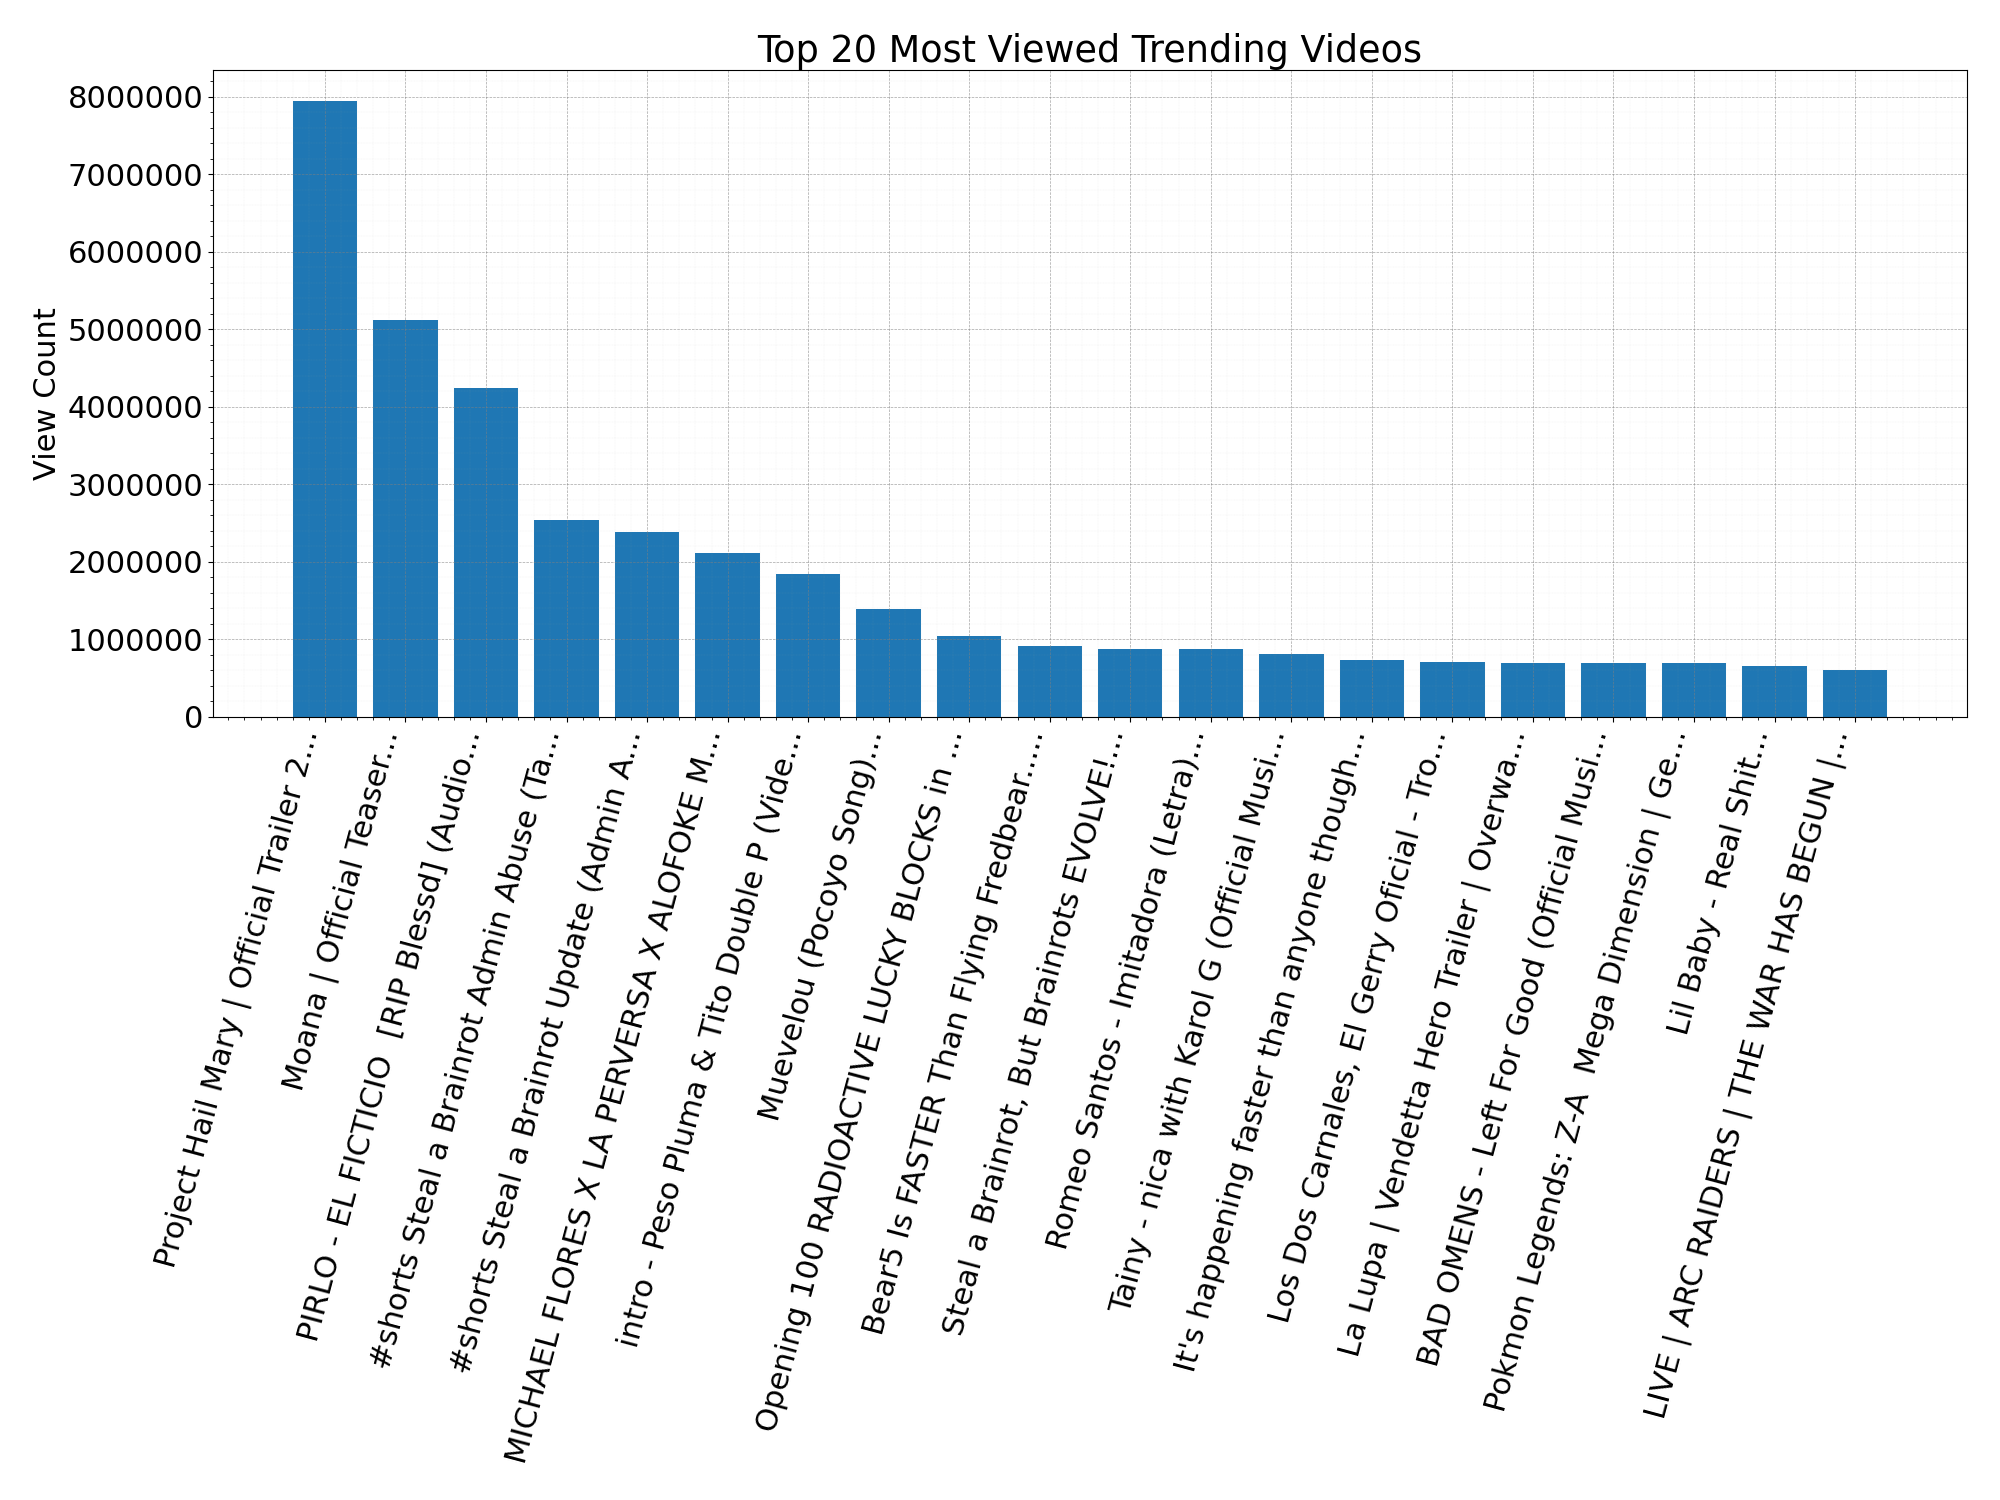

In [5]:
pdf_us = get_top_videos_by_region("US", 20)
pdf_us.head()
title = f"Top {len(pdf_top_plot)} Most Viewed Trending Videos in US"
plt = plot_data(pdf_us, title)
%matplot plt

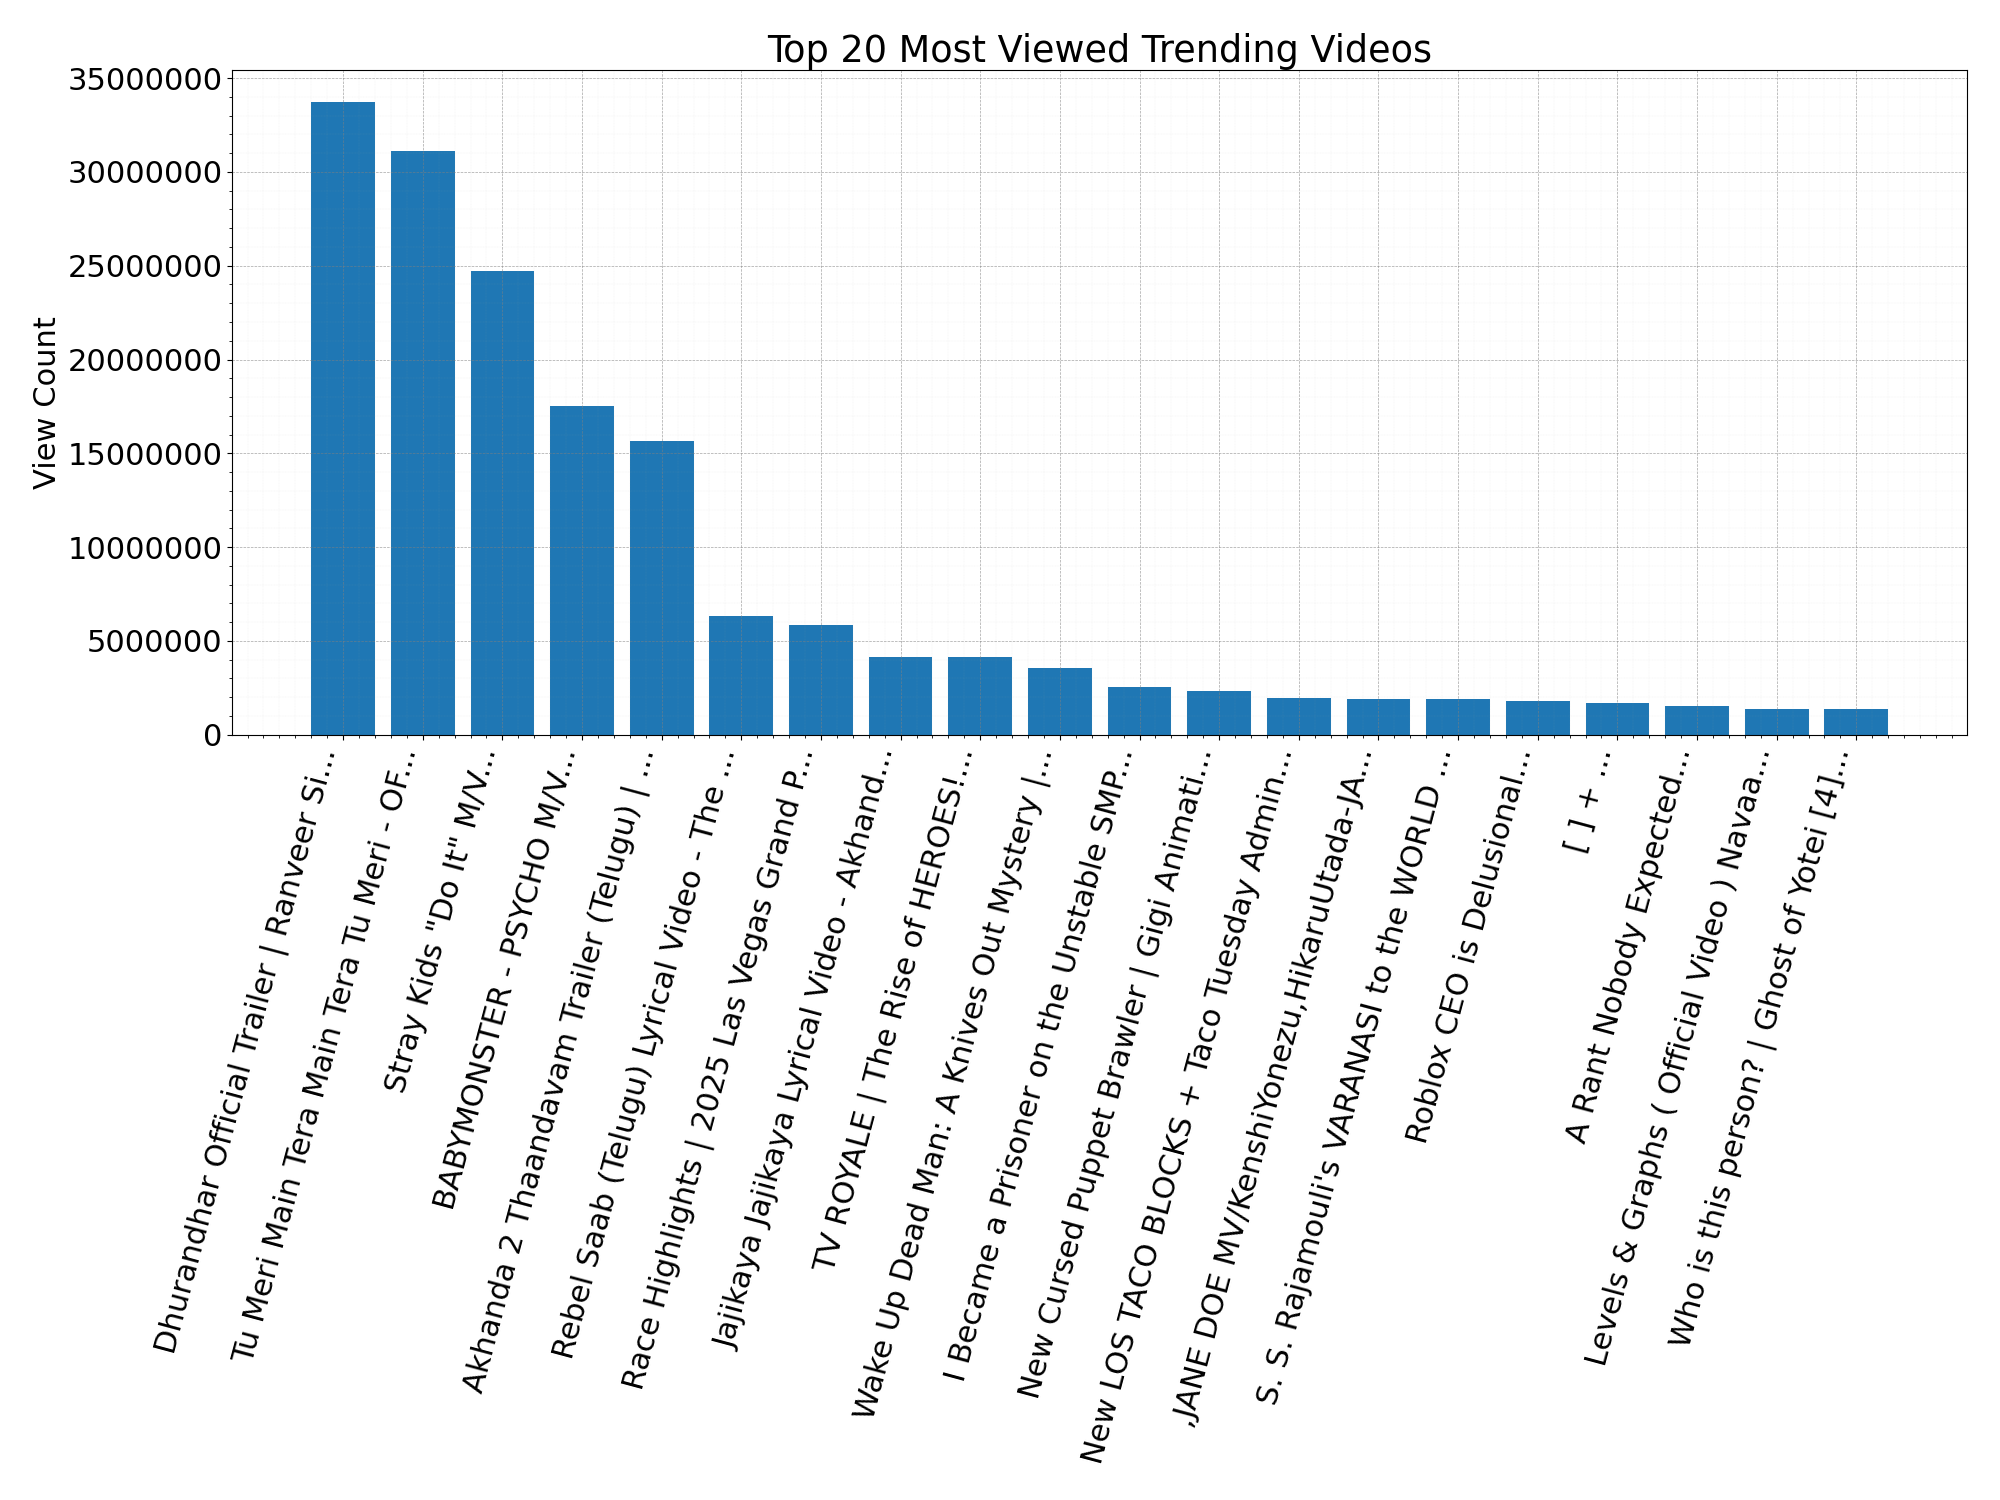

In [6]:
pdf_us = get_top_videos_by_region("CA", 20)
pdf_us.head()
plt = plot_data(pdf_us)
%matplot plt

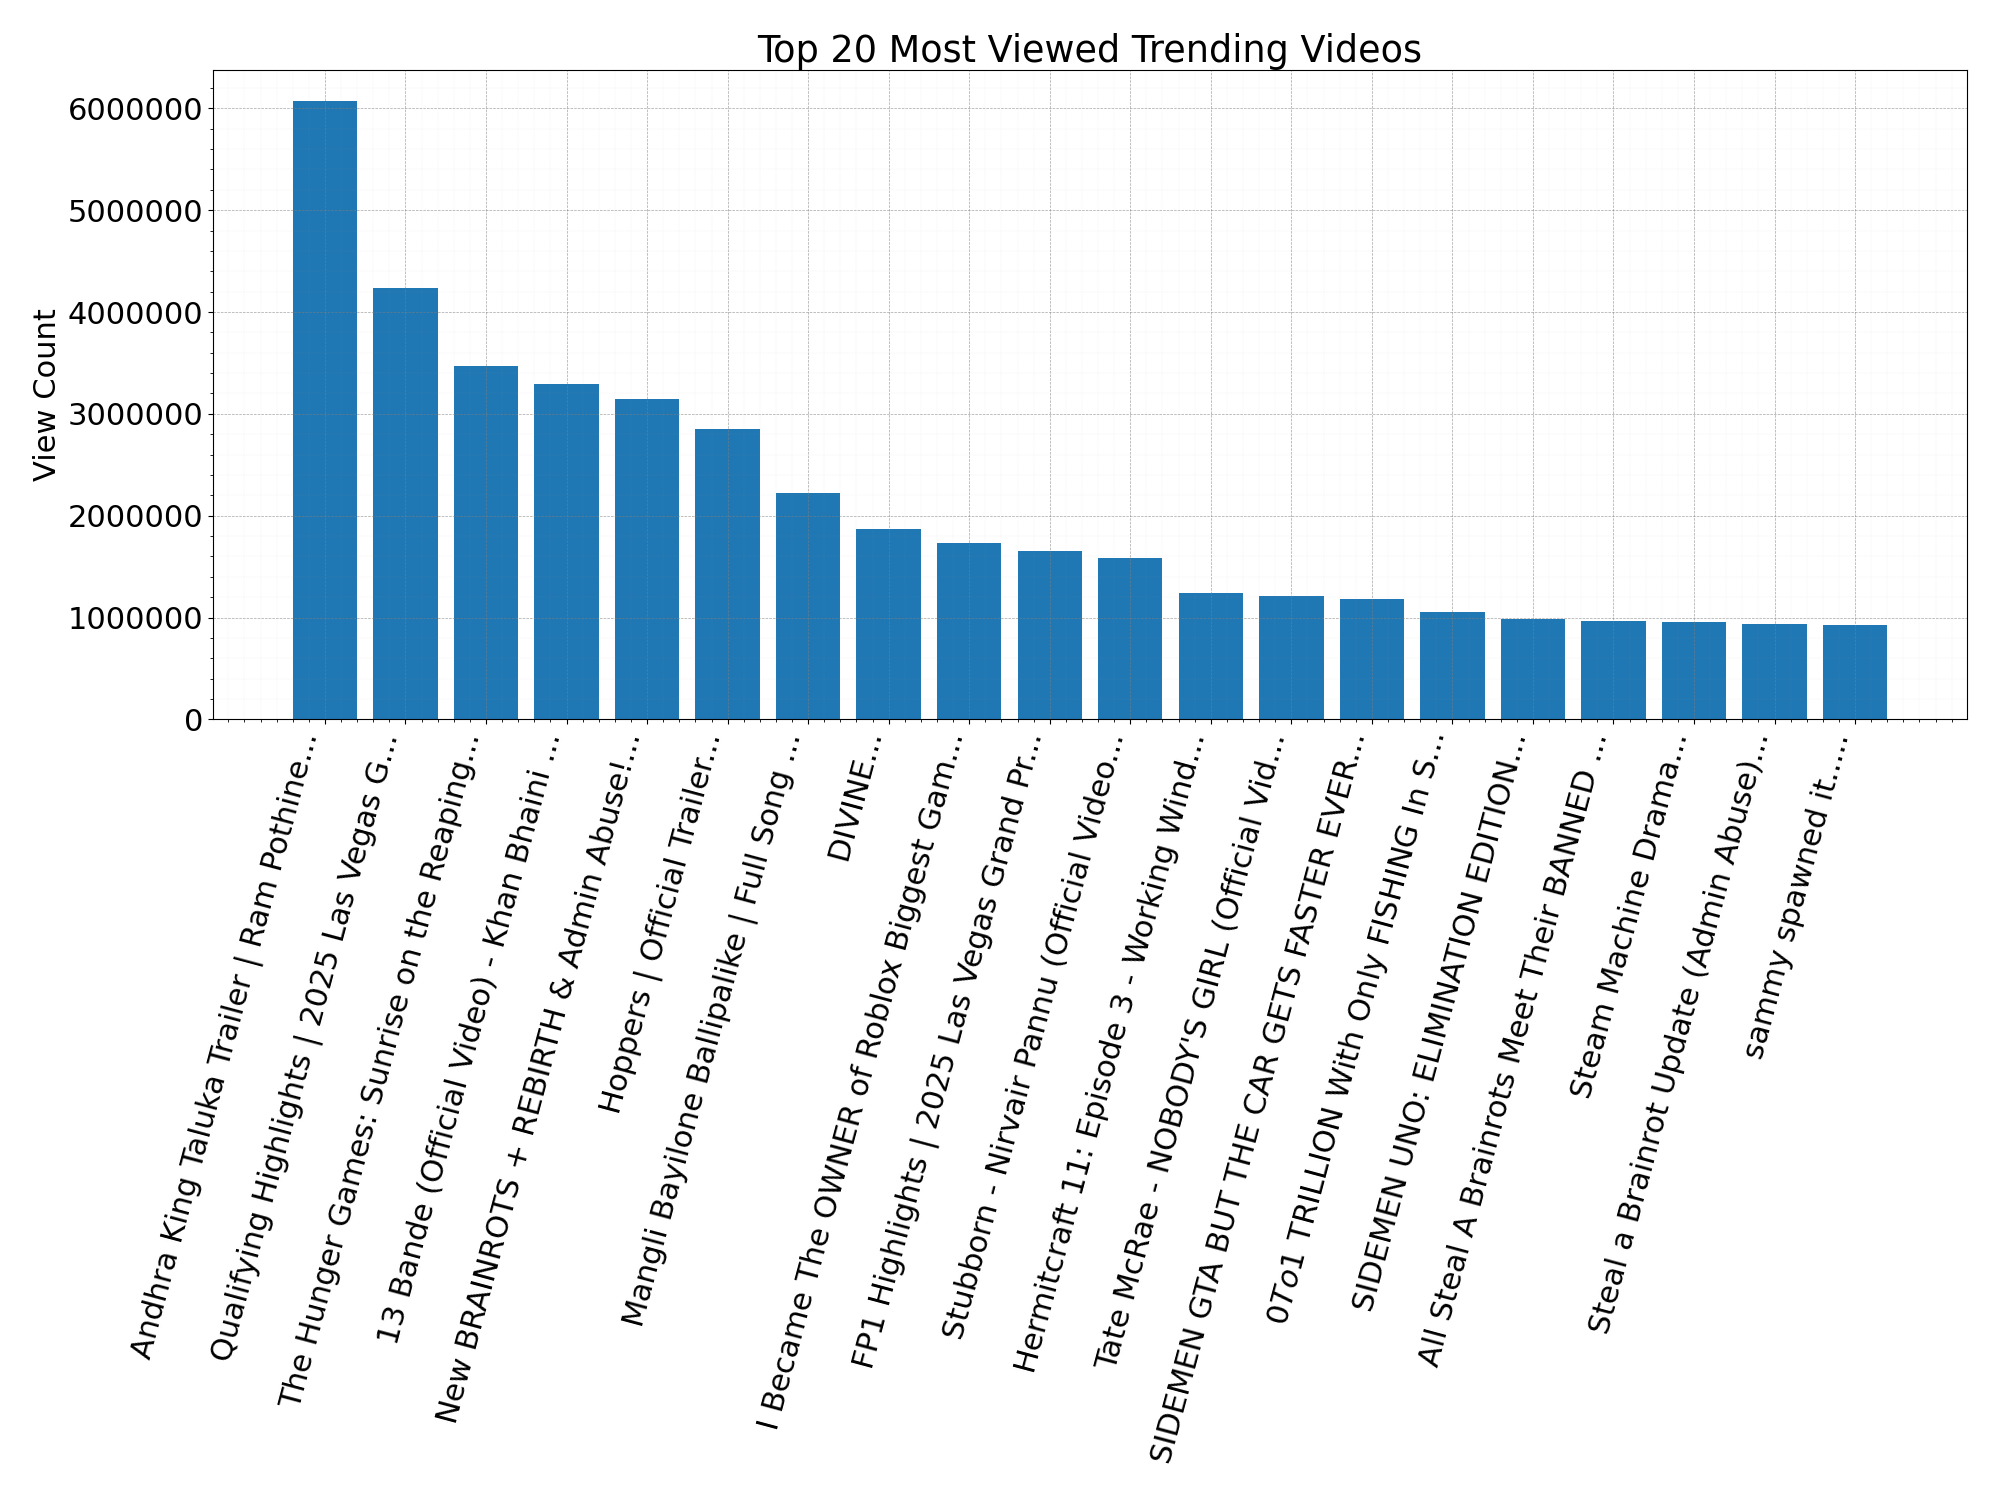

In [7]:
pdf_us = get_top_videos_by_region("GB", 20)
pdf_us.head()
plt = plot_data(pdf_us)
%matplot plt